In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import copy
import matplotlib.pyplot as plt  # Import for plotting

In [2]:
# Define the CNN architecture (modified with batch normalization)
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super(SimpleCNN, self).__init__()

        # Define the layers of the network with batch normalization
        self.layer1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization
        self.layer2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.layer3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Adaptive pooling layer to make sure the output feature map size is always 7x7
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply layers in sequence with ReLU and batch normalization
        x = self.relu(self.bn1(self.layer1(x)))  # Apply batch norm before ReLU
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.relu(self.bn3(self.layer3(x)))

        # Apply adaptive pooling to make feature map size (7, 7)
        x = self.adaptive_pool(x)

        # Flatten the tensor
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch size

        # Apply fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Load the dataset (supporting both MNIST and CIFAR-10)
def load_data(batch_size=32, dataset_name='MNIST'):
    if dataset_name == 'MNIST':
        transform = transforms.Compose([
            transforms.RandomRotation(10),  # Random rotation
            transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random translation
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        # Download the MNIST dataset
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        input_channels = 1  # MNIST is grayscale
        num_classes = 10
    elif dataset_name == 'CIFAR10':
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        # Download the CIFAR-10 dataset
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        input_channels = 3  # CIFAR-10 is RGB
        num_classes = 10
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    return train_dataset, test_dataset, input_channels, num_classes


In [4]:
# Split dataset into partitions for federated learning
def partition_dataset(dataset, n_clients=10):
    split_size = len(dataset) // n_clients
    return random_split(dataset, [split_size] * n_clients)


In [5]:
# Local training for each client
def client_update(client_model, optimizer, train_loader, device, epochs=1):
    client_model.train()
    running_loss = 0.0
    for epoch in range(epochs):
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            loss = nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    return running_loss / len(train_loader)

In [6]:
# Aggregating models from clients (FedAvg)
def server_aggregate(global_model, client_models, client_datasets):
    global_dict = global_model.state_dict()
    total_data_size = sum(len(dataset) for dataset in client_datasets)

    for k in global_dict.keys():
        weighted_avg = torch.zeros_like(global_dict[k], dtype=torch.float32)  # Ensure it's float32
        for i in range(len(client_models)):
            weight = len(client_datasets[i]) / total_data_size
            weighted_avg += weight * client_models[i].state_dict()[k].to(torch.float32)  # Cast to float32 if necessary

        global_dict[k] = weighted_avg

    global_model.load_state_dict(global_dict)

In [7]:
# Evaluate global model on test dataset
def test_model(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.96MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Global Epoch 1/10
Client 1 training...
Client 2 training...
Client 3 training...
Client 4 training...
Client 5 training...
Client 6 training...
Client 7 training...
Client 8 training...
Client 9 training...
Client 10 training...
Test Accuracy after round 1: 90.75
Global Epoch 2/10
Client 1 training...
Client 2 training...
Client 3 training...
Client 4 training...
Client 5 training...
Client 6 training...
Client 7 training...
Client 8 training...
Client 9 training...
Client 10 training...
Test Accuracy after round 2: 92.38
Global Epoch 3/10
Client 1 training...
Client 2 training...
Client 3 training...
Client 4 training...
Client 5 training...
Client 6 training...
Client 7 training...
Client 8 training...
Client 9 training...
Client 10 training...
Test Accuracy after round 3: 92.72
Global Epoch 4/10
Client 1 training...
Client 2 training...
Client 3 training...
Client 4 training...
Client 5 training...
Client 6 t

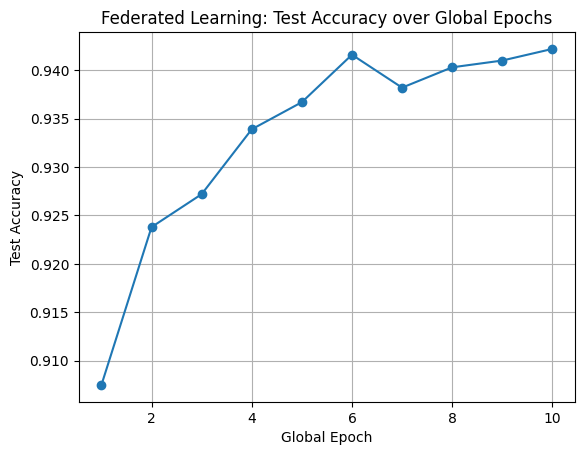

Federated learning process completed.


In [8]:
# Federated Learning process with accuracy tracking
def federated_learning(n_clients=10, global_epochs=10, local_epochs=5, batch_size=32, dataset_name='MNIST'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the dataset and partition it for clients
    train_dataset, test_dataset, input_channels, num_classes = load_data(batch_size, dataset_name)
    client_datasets = partition_dataset(train_dataset, n_clients)
    client_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in client_datasets]
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    # Initialize global model and create copies for clients
    global_model = SimpleCNN(input_channels=input_channels, num_classes=num_classes).to(device)
    client_models = [copy.deepcopy(global_model) for _ in range(n_clients)]

    # Optimizers for each client
    optimizers = [optim.AdamW(model.parameters(), lr=0.001) for model in client_models]
    schedulers = [optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) for optimizer in optimizers]

    # List to store accuracy values for plotting
    accuracy_history = []

    # Federated Learning process
    for global_epoch in range(global_epochs):
        print(f"Global Epoch {global_epoch+1}/{global_epochs}")

        # Clients train locally
        for client_idx in range(n_clients):
            print(f"Client {client_idx+1} training...")
            client_update(client_models[client_idx], optimizers[client_idx], client_loaders[client_idx], device, local_epochs)

        # Aggregate client models to update global model
        server_aggregate(global_model, client_models, client_datasets)

        # Reduce learning rate for each client
        for scheduler in schedulers:
            scheduler.step()

        # Evaluate the global model on the test dataset
        test_accuracy = test_model(global_model, test_loader, device)
        print(f"Test Accuracy after round {global_epoch+1}: {test_accuracy*100:.2f}")

        # Store accuracy for plotting
        accuracy_history.append(test_accuracy)

    # Plot accuracy over global epochs
    plt.plot(range(1, global_epochs+1), accuracy_history, marker='o')
    plt.title('Federated Learning: Test Accuracy over Global Epochs')
    plt.xlabel('Global Epoch')
    plt.ylabel('Test Accuracy')
    plt.grid(True)
    plt.show()

    # Save the final global model
    torch.save(global_model.state_dict(), 'federated_model.pth')
    print("Federated learning process completed.")

if __name__ == '__main__':
    # Run federated learning with 10 clients, global epochs=10, local epochs=5, and batch size 32
    federated_learning(n_clients=10, global_epochs=10, local_epochs=5, batch_size=32, dataset_name='MNIST')